# Intro To GraphQL For Data Scientists

![](../img/graphql.png)

This notebook covers querying GraphQL using Python and using GraphQL as a data source for graph data science with Neo4j.

Outline:

* Querying The Meetup API
* Working with GraphQL data in a DataFrame
* Neo4j and Graph Data Science
* Visualizing Graph Data
* Exposing Data Science Via GraphQL

In [7]:
#!pip install gql neo4j-driver pandas aiohttp

# Querying The Meetup API 

![](../img/meetup.png)

Meetup offers a GraphQL API, however it requires authentication using OAuth ([see docs here](https://www.meetup.com/api/authentication/#p02-server-flow-section)). The OAuth authentication flow will generate an authorization token that will need to passed as a header with each GraphQL request. You'll need an authorization token to query the Meetup API. The Meetup API uses the OAuth flow to manage tokens so you'll need to follow the steps described [here](https://www.meetup.com/api/authentication/#p02-server-flow-section), including creating a new OAuth consumer app which must be approved by Meetup and can take several days.


Alternatively I created [a helpful app](https://github.com/simonbrownsb/meetupdata#access-token) to generate your Meetup token [https://meetup-auth-key.vercel.app/](https://meetup-auth-key.vercel.app/)- just know that this isn't an official Meetup app, which you may not trust.

Once you have your Meetup API token it can be used A GraphQL request is an HTTP POST request to `https://api.meetup.com/gql`. Authorization is done by setting an Authorization header on the HTTP request using a bearer token.

```
{"Authorization": "Bearer <YOUR_TOKEN_HERE?"}
```

We will be using the [GQL Python GraphQL client](https://gql.readthedocs.io/en/latest/intro.html#installation) which will handle the GraphQL request / response lifecycle and setting the appropriate request headers.

In [2]:
import os

In [3]:
# Read MEETUP_SECRET from environment variables

# Replace with your Meetup API token
# See: https://www.meetup.com/api/authentication/#p02-server-flow-section
MEETUP_SECRET = os.getenv('MEETUP_SECRET')

In [4]:
import pprint
from gql import Client, gql
from gql.transport.aiohttp import AIOHTTPTransport

# Select your transport with a defined url endpoint
transport = AIOHTTPTransport(
    url="https://api.meetup.com/gql",
    headers={"Authorization": "Bearer " + MEETUP_SECRET},
)


# Create a GraphQL client using the defined transport
client = Client(transport=transport, fetch_schema_from_transport=False)

# Provide a GraphQL query
query = gql(
    """
    query { self { id name } }
"""
)

# Execute the query on the transport
result = await client.execute_async(query)
print(result)

{'self': {'id': '40626372', 'name': 'Will Lyon'}}


## Find The Data Umbrella Meetup Group

![](../img/graphql1.png)

Notice how the nested selection set in the GraphQL query is describing a traversal through the data graph.

```GraphQL
query {
      groupByUrlname(urlname: "data-umbrella") {
        id
        name
        link
        topics {
          name
        }
      }
    }
```



In [5]:
# Find the Data Umbrella Meetup group and its topics

query = gql(
    """
    query {
      groupByUrlname(urlname: "data-umbrella") {
        id
        name
        link
        topics {
          name
        }
      }
    }
    """
)


result = await client.execute_async(query)
pprint.pprint(result)

{'groupByUrlname': {'id': '33067477',
                    'link': 'https://www.meetup.com/data-umbrella',
                    'name': 'Data Umbrella',
                    'topics': [{'name': 'Business Analytics'},
                               {'name': 'Artificial Intelligence Applications'},
                               {'name': 'Data Visualization'},
                               {'name': 'Data Analytics'},
                               {'name': 'Open Source'},
                               {'name': 'Data Science'},
                               {'name': 'Data Science using Python'},
                               {'name': 'Python'},
                               {'name': 'Deep Learning'},
                               {'name': 'Artificial Intelligence'},
                               {'name': 'Machine Learning'}]}}


## Find Data Umbrella's Upcoming Events

![](../img/graphql2.png)

This query uses a ["connection type"](https://relay.dev/graphql/connections.htm) to represent connections. These connection types can be useful for pagination and metadata about the relationships (think relationship properties).

```GraphQL
query {
      groupByUrlname(urlname: "data-umbrella") {
        name
        upcomingEvents(input: {first: 10}) {
          count
          edges {
            node {
              id
              title
              eventUrl
              dateTime
              host {
                name
              }
            }
          }
        }
      }
    }
```



In [6]:
# Find upcoming events and the host

query = gql(
    """
    query {
      groupByUrlname(urlname: "data-umbrella") {
        name
        upcomingEvents(input: {first: 10}) {
          count
          edges {
            node {
              id
              title
              eventUrl
              dateTime
              host {
                name
              }
            }
          }
        }
      }
    }
    """
)


result = await client.execute_async(query)
pprint.pprint(result)

{'groupByUrlname': {'name': 'Data Umbrella',
                    'upcomingEvents': {'count': 0, 'edges': []}}}


## Who RSVPd For This Event?

![](../img/graphql3.png)

```GraphQL
query {
      event(id: "284764217!chp") {
        title
        tickets {
          count
          edges {
            node {
              status
              createdAt
              user {
                name
              }
              
            }
          }
        }
      }
    }
```

In [7]:
# Who RSVPd for this event?

query = gql(
    """
    query {
      event(id: "284764217!chp") {
        title
        tickets {
          count
          edges {
            node {
              status
              createdAt
              user {
                name
              }
              
            }
          }
        }
      }
    }
    """
)


result = await client.execute_async(query)
pprint.pprint(result)

{'event': {'tickets': {'count': 100,
                       'edges': [{'node': {'createdAt': '2023-01-28T13:53:00.366Z[UTC]',
                                           'status': 'YES',
                                           'user': {'name': 'Beryl Kanali'}}},
                                 {'node': {'createdAt': '2023-01-28T13:53:00.366Z[UTC]',
                                           'status': 'YES',
                                           'user': {'name': 'Reshama Shaikh'}}},
                                 {'node': {'createdAt': '2023-01-28T13:53:00.366Z[UTC]',
                                           'status': 'YES',
                                           'user': {'name': 'Crystal Lee'}}},
                                 {'node': {'createdAt': '2023-01-28T13:53:00.366Z[UTC]',
                                           'status': 'YES',
                                           'user': {'name': 'Daniel Gray'}}},
                                 {'node': {'created

## Search For Groups By Keyword

![](../img/graphql4.png)


Note the use of the inline fragment to handle an abstract type in GraphQL.
```GraphQL
... on Group {
  name
  urlname
  pastEvents(input: {first: 10}) {
    count
  }
  topics {
    name
  }
}
```

In [8]:
# Group search by keyword ("data" or similar)

query = gql(
    """
    query { 
      keywordSearch(filter: {query: "data", lon: -122.42, lat: 37.78, source: GROUPS }) {
        count
        edges {
          node {
            result {
              ... on Group {
                name
                urlname
                pastEvents(input: {first: 10}) {
                  count
                }
                topics {
                  name
                }
              }
            }
          }
        }
      }
    }
    """
)


result = await client.execute_async(query)
groups_list = result["keywordSearch"]["edges"]
pprint.pprint(groups_list)

[{'node': {'result': {'name': 'San Francisco Tech Startup or Hackathon Meetup '
                              'Group',
                      'pastEvents': {'count': 0},
                      'topics': [{'name': 'New Technology'},
                                 {'name': 'Web Technology'},
                                 {'name': 'Network Security'},
                                 {'name': 'Hacking'},
                                 {'name': 'Information Security'},
                                 {'name': 'Internet Startups'},
                                 {'name': 'Hackers and Makers'},
                                 {'name': 'Technology Startups'},
                                 {'name': 'Computer Security'}],
                      'urlname': 'san-francisco-tech-startup-or-hackathon-meetup-group'}}},
 {'node': {'result': {'name': 'Big Data, San Francisco',
                      'pastEvents': {'count': 263},
                      'topics': [{'name': 'Social Networking'},


# Working With GraphQL Data In A DataFrame

In [9]:
# Let's see how we can work with this data in a DataFrame

import pandas as pd

In [10]:
# We'll use DataFrame.from_dict to create a DataFrame from the GraphQL response data
# Then pull out the integer value for pastEvents and the list of topics

df = pd.DataFrame.from_dict([x['node']['result'] for x in groups_list])

# {count: 3} ==> 3
df['pastEvents'] = df['pastEvents'].apply(lambda x: x['count']) 

# [{name: "AI"}, {name: "BI"}] ==> ["AI", "BI"]
df['topics'] = df['topics'].apply(lambda x: [f['name'] for f in x]) 
df

,name,urlname,pastEvents,topics
0,San Francisco Tech Startup or Hackathon Meetup...,san-francisco-tech-startup-or-hackathon-meetup...,0,"[New Technology, Web Technology, Network Secur..."
1,"Big Data, San Francisco",BigDataSanFran,263,"[Social Networking, Open Source, Business Stra..."
2,Data for Good,DataScienceforGood,131,"[Data Science, Social Impact, Open Data, Machi..."
3,Data Council SF Data Engineering & Science,Data-Council-SF-Data-Engineering-Science,36,"[Open Source, Software Development, Big Data, ..."
4,Future Data,future-data,0,"[Artificial Intelligence, Open Source, Robotic..."
5,Data Mash,data-mash,5,"[Data Management, Data Science using Python, D..."
6,Data Science Salon | San Francisco,data-science-salon-sf,140,"[Business Analytics, Big Data, Business Intell..."
7,San Francisco Data Science ODSC,San-Francisco-ODSC,255,"[Artificial Intelligence, Open Source, Python,..."
8,AppDev for Data Pros,appdevpro,2,"[Open Source, Database Professionals, Software..."
9,Data Science for Sustainability,Data-Science-for-Sustainability,79,"[Green Entrepreneurs, Sustainable Energy, Pyth..."


<AxesSubplot:xlabel='name'>

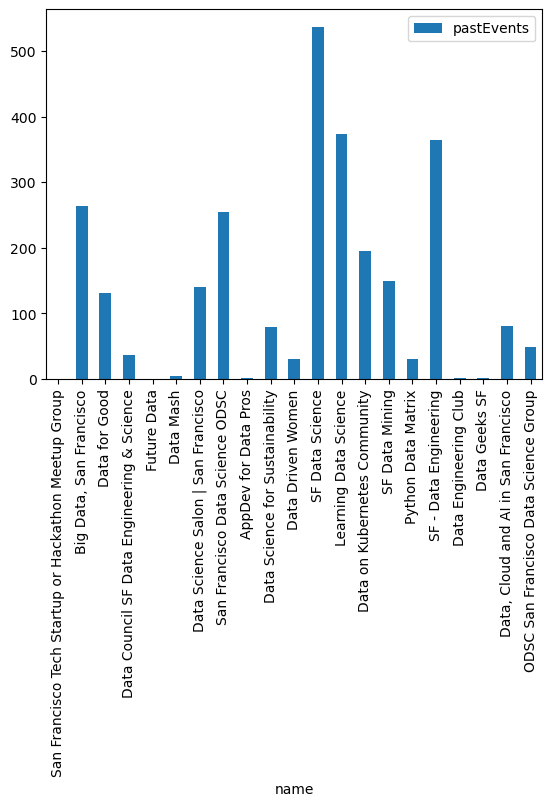

In [11]:
# Distribution of past events for each group

df.plot.bar(y="pastEvents", x="name")

We've seen that the response data from a GraphQL request is a dict / list of dicts and how to work with that data in a DataFrame. Let's see how to incorporate that data into other data science tooling, in this case with Neo4j.

# Graph Data Science With Neo4j Sandbox

Neo4j is a graph database that can enable us to analyze graph data using graph algorithms (among other things), using the Graph Data Science (GDS) library. We'll use Neo4j Sandbox to spin up a free hosted Neo4j instance in the cloud, load our Meetup data and then analyze our data with graph algorithms.


* Sign up for a free Neo4j Sandbox at [dev.neo4j.com/sandbox](https://dev.neo4j.com/sandbox) (then "Launch the Free Sandbox" button)
* Select the "Blank Sandbox"
* Once your Neo4j Sandbox is live, select "Connection Details"
* Set your Neo4j connection credentials below

<!-- ![](../img/sandbox_usecase.png) -->


![](../img/sandbox_creds.png)


In [12]:
# Replace with your own credentials or set environment variables
NEO4J_URI = os.getenv('NEO4J_URI')
NEO4J_USER = os.getenv('NEO4J_USER')
NEO4J_PASSWORD = os.getenv('NEO4J_PASSWORD')

We'll be using the Neo4j Python driver to manage our connection to Neo4j and sending queries to the database using [Cypher](https://neo4j.com/developer/cypher/), the query language for Neo4j. 

In [13]:
from neo4j import GraphDatabase, basic_auth

driver = GraphDatabase.driver(NEO4J_URI, auth=basic_auth(NEO4J_USER, NEO4J_PASSWORD))

In [15]:
# Test query - return number of nodes in the database
cypher_query = """
MATCH (a) RETURN COUNT(a) AS num
"""

with driver.session() as session:
    results = session.execute_read(
        lambda tx: tx.run(cypher_query).data()
    )
    for record in results:
        print("Number of nodes: ", record["num"])



Number of nodes:  0


In [17]:
# Load our Groups and Topics data
load_groups_query = """
UNWIND $data AS row
WITH row.node.result AS group
MERGE (g:Group {name: group.name})
SET g.urlname    = group.urlname,
    g.eventCount = group.pastEvents.count

FOREACH (topic IN group.topics |
  MERGE (t:Topic {name: topic.name})
  MERGE (g)-[:HAS_TOPIC]->(t)
)

RETURN COUNT(*) AS num_groups
"""

with driver.session() as session:
    results = session.execute_write(
        lambda tx: tx.run(load_groups_query, data=groups_list).data()
    )
    for record in results:
        print(record)

{'num_groups': 21}



Graph data visualization is an important tool to interpret the results of graph algorithms. We can visualize the results using tools like [Neo4j Bloom.](https://neo4j.com/product/bloom/) To launch Neo4j Bloom select the "Open" dropdown for your Neo4j Sandbox and select "Open With Bloom"

![](../img/sandbox_bloom.png)

You'll need to provide the database password when launching Bloom. The first time you launch Bloom you'll need to create a "perspective" which configures how data is displayed by Bloom. Let's use the default perspective for now.

![](../img/bloom_1.png)
Let's see how we can improve our ability to analyze the network of groups and topics using graph algorithms.


In [18]:
# Compute degre centrality for each topic node
degree_query = """
MATCH (t:Topic)
WITH t, SIZE( (t)<-[:HAS_TOPIC]-(:Group) ) AS degree
SET t.degree = degree
RETURN COUNT(*) AS num_updated
"""

with driver.session() as session:
    results = session.execute_write(
        lambda tx: tx.run(degree_query).data()
    )
    for record in results:
        print(record)

{'num_updated': 96}


We can use the degree centrality property value to style our graph visualization, allowing us to see the most important topics at a glance.

![](../img/bloom_2.png)

## Graph Data Science with Neo4j

Let's see how we can use the [Neo4j Graph Data Science library](https://neo4j.com/docs/graph-data-science/current/) with our Meetup Data.

In [19]:
# First, we'll need to project a graph for use with GDS
project_gds_query = """
CALL gds.graph.project(
    'topics',
    ['Group','Topic'],
    'HAS_TOPIC'
)
YIELD
    graphName, nodeCount, relationshipCount
RETURN *
"""

with driver.session() as session:
    results = session.execute_write(
        lambda tx: tx.run(project_gds_query).data()
    )
    for record in results:
        print(record)

{'graphName': 'topics', 'nodeCount': 117, 'relationshipCount': 240}


Next, let's use the [node similarity algorithm](https://neo4j.com/docs/graph-data-science/current/algorithms/node-similarity/) to find similar nodes based on overlapping topics. This procedure will add `SIMILAR` relationships between groups to the graph, storing the similarity score (an indication of how "similar" two groups are) as a relationship property.

![](../img/similar.png)

In [20]:
# Node similarity algorithm
node_similarity = """
CALL gds.nodeSimilarity.write(
    'topics',
    {
        topK: 3,
        writeRelationshipType: 'SIMILAR',
        writeProperty: 'score'
    }
)
YIELD nodesCompared, relationshipsWritten
"""

with driver.session() as session:
    results = session.execute_write(
        lambda tx: tx.run(node_similarity).data()
    )
    for record in results:
        print(record)

{'nodesCompared': 21, 'relationshipsWritten': 63}


In [7]:
# Finally close the database driver 
driver.close()

Next, let's see how to use GraphQL to create an API that will show recommended groups using the node similarity graph algorithm.

Open in [CodeSandbox](https://codesandbox.io/s/github/johnymontana/graphql-for-data-scientists/tree/main/graphql)